# Importation des librairies

In [ ]:
%pip install 

In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# Importation des données

In [2]:
dossier = "datanba" #Nom du dossier contenant l'ensemble de mes saisons
saisons_csv = [saison for saison in os.listdir(dossier) if saison.endswith(".csv")] #Liste des noms de l'ensemble de mes saisons
df = []

for saison in saisons_csv : #Pour chaque saison :
    annee = int(saison.split(".")[0]) #Récupérer l'année
    saison_annee = pd.read_csv(os.path.join(dossier, saison), sep=';') #L'importer
    saison_annee['Saison'] = annee #Création d'une colonne année
    df.append(saison_annee) #Ajout de la colonne année

df_complet = pd.concat(df) #Concaténation en un seul dataframe

# Qualités des données

### Traitement du séparateur des milliers : ","

In [3]:
for v in df_complet.select_dtypes(include=['object']).columns :
    if df_complet[v].str.contains(',').any(): 
        df_complet[v] = df_complet[v].str.replace(',', '').astype(float)

### Détection des valeurs nulles

In [4]:
var_null = [] #Initialisation de la liste de mes variables contenant des valeurs nulles
for v in df_complet : #Pour chaque variable :
    verif = df_complet[v].isnull().sum() #Compter le nombre de valeurs nulles
    if verif > 0 : #Si supérieur à 0 :
        print(f"{v}: {verif} valeurs nulles") #Afficher
        var_null.append(v) #Ajout dans la liste var_null

Attend./G: 11 valeurs nulles
AS: 29 valeurs nulles


### Traitement des valeurs nulles par la méthode des k plus proches voisins (k=5)

In [5]:
var_keep = df_complet.drop(columns=var_null).select_dtypes(include=['float64', 'int64']) #Sélection des variables quantitatives (knn agit mal sur les qualis)
df_knn = pd.concat([df_complet[var_null], var_keep], axis=1) 
imputer = KNNImputer(n_neighbors=5) #k=5
df_impute = pd.DataFrame(imputer.fit_transform(df_knn), columns=df_knn.columns)

#Imputation des nouvelles valeurs
for v in var_null:
    df_complet[v] = df_complet[v].fillna(df_impute[v])

#Vérification qu'il n'y a plus de var_null
for v in df_complet :
    verif = df_complet[v].isnull().sum()
    if verif > 0 :
        print(f"{v}: {verif} valeurs nulles")

### Traitement des "*" dans la variable "Team"

In [6]:
distinct_teams_before = df_complet['Team'].unique()
print(distinct_teams_before)
df_complet["Team"] = df_complet["Team"].str.replace('*', '', regex=False)
distinct_teams_after = df_complet['Team'].unique()
print(distinct_teams_after)

['Boston Celtics' 'Los Angeles Lakers' 'Philadelphia 76ers'
 'Seattle SuperSonics' 'Phoenix Suns*' 'Atlanta Hawks*' 'Milwaukee Bucks*'
 'Kansas City Kings*' 'Houston Rockets*' 'San Antonio Spurs*'
 'Washington Bullets*' 'New York Knicks' 'Portland Trail Blazers*'
 'Cleveland Cavaliers' 'Indiana Pacers' 'San Diego Clippers'
 'New Jersey Nets' 'Chicago Bulls' 'Denver Nuggets'
 'Golden State Warriors' 'Utah Jazz' 'Detroit Pistons' 'Boston Celtics*'
 'Philadelphia 76ers*' 'Los Angeles Lakers*' 'New York Knicks*'
 'Chicago Bulls*' 'Indiana Pacers*' 'Washington Bullets' 'Atlanta Hawks'
 'Dallas Mavericks' 'Seattle SuperSonics*' 'Denver Nuggets*'
 'New Jersey Nets*' 'Portland Trail Blazers' 'Kansas City Kings'
 'Houston Rockets' 'Detroit Pistons*' 'Utah Jazz*' 'Dallas Mavericks*'
 'San Antonio Spurs' 'Cleveland Cavaliers*' 'Los Angeles Clippers'
 'Sacramento Kings*' 'Phoenix Suns' 'Golden State Warriors*'
 'Sacramento Kings' 'Charlotte Hornets' 'Miami Heat'
 'Minnesota Timberwolves' 'Orlando 

### Modifications des variables

##### Transformation des variables W, L et PW, PL via un ratio --> "W/L" et "PW/PL" :

In [7]:
df_complet["W/L"] = df_complet["W"]/(df_complet["W"]+df_complet["L"])
df_complet = df_complet.drop(columns=["W","L"])

df_complet["PW/PL"] = df_complet["PW"]/(df_complet["PW"]+df_complet["PL"])
df_complet = df_complet.drop(columns=["PW","PL"])

# Création des subsets

### Exploration de la "Pace" et du "3PAr" par saison

In [8]:
df_moyennes_saison = df_complet.groupby('Saison')[['Pace', '3PAr']].mean()

### Clustering par le croisement de Pace et 3PAr :

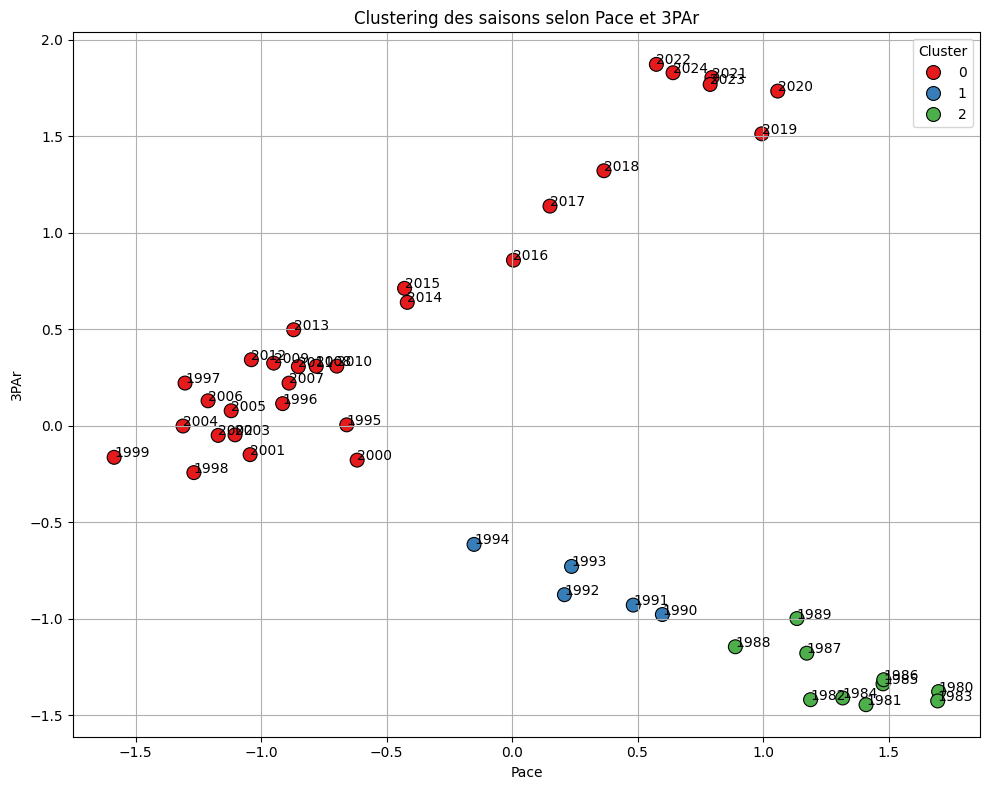

In [9]:
scaler = StandardScaler()
df_moyennes_saison[['Pace','3PAr']] = scaler.fit_transform(df_moyennes_saison[['Pace','3PAr']])

# Appliquer KMeans avec les données standardisées
kmeans = KMeans(n_clusters=3, random_state=42)
df_moyennes_saison['Cluster'] = kmeans.fit_predict(df_moyennes_saison[['Pace','3PAr']])

# Visualiser les clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_moyennes_saison['Pace'], y=df_moyennes_saison['3PAr'], hue=df_moyennes_saison['Cluster'],
                palette="Set1", marker='o', s=100, edgecolor='black',)

for i in range(len(df_moyennes_saison)):
    plt.text(df_moyennes_saison['Pace'].iloc[i], df_moyennes_saison['3PAr'].iloc[i], 
             df_moyennes_saison.index[i], fontsize=10, ha='left')

plt.title('Clustering des saisons selon Pace et 3PAr')
plt.xlabel('Pace')
plt.ylabel('3PAr')
plt.grid(True)
plt.tight_layout()
plt.show()

### Clustering par 3PAr :

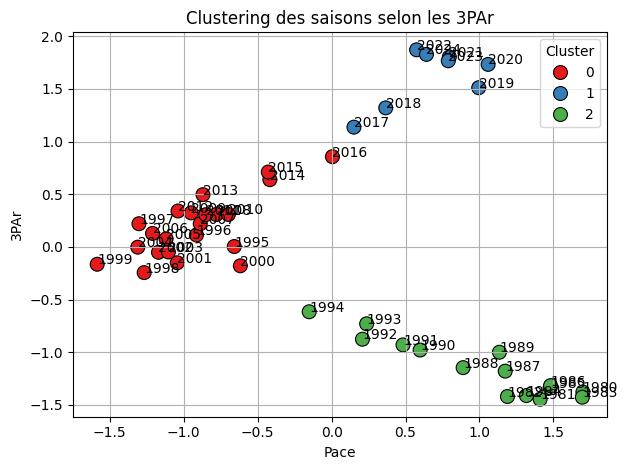

In [10]:
scaler = StandardScaler()
df_moyennes_saison[['3PAr']] = scaler.fit_transform(df_moyennes_saison[['3PAr']])

# Appliquer KMeans avec les données standardisées
kmeans = KMeans(n_clusters=3, random_state=42)
df_moyennes_saison['Cluster'] = kmeans.fit_predict(df_moyennes_saison[['3PAr']])

# Visualiser le graphique avec les nouveaux cluster
# plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_moyennes_saison['Pace'], y=df_moyennes_saison['3PAr'], hue=df_moyennes_saison['Cluster'],
                palette="Set1", marker='o', s=100, edgecolor='black',)

for i in range(len(df_moyennes_saison)):
    plt.text(df_moyennes_saison['Pace'].iloc[i], df_moyennes_saison['3PAr'].iloc[i], 
             df_moyennes_saison.index[i], fontsize=10, ha='left')

plt.title('Clustering des saisons selon les 3PAr')
plt.xlabel('Pace')
plt.ylabel('3PAr')
plt.grid(True)
plt.tight_layout()
plt.show()

### Création des subsets :

In [11]:
saison_to_cluster = df_moyennes_saison['Cluster'].to_dict()
df_complet['Cluster'] = df_complet['Saison'].map(saison_to_cluster)

subsets = {}
for cluster in df_complet['Cluster'].unique():
    subsets[cluster] = df_complet[df_complet['Cluster'] == cluster]

sub_sets = []
for cluster_label in df_complet['Cluster'].unique():
    subset = df_complet[df_complet['Cluster'] == cluster_label]
    sub_sets.append(subset)

subsets_named = {}
for cluster, subset in subsets.items():
    saison_min = subset['Saison'].min()
    saison_max = subset['Saison'].max()
    subset_name = f"{saison_min} - {saison_max}"
    subsets_named[subset_name] = subset

for subset_name, subset in subsets_named.items():
    filename = f"{subset_name}.csv"
    subset.to_csv(filename, index=False, encoding="ANSI", sep=";")

### Vérification de la distribution de notre variable cible (Rounds) pour chaque subsets : 

In [12]:
for i, subset in enumerate(sub_sets):
    print(f"Distribution des classes pour Subset {i+1}:")
    print(subset['Rounds'].value_counts(normalize=True))
    print()

Distribution des classes pour Subset 1:
Rounds
NP        0.387978
ECFR      0.142077
WCFR      0.142077
ECSF      0.081967
WCSF      0.081967
ECF       0.040984
WCF       0.040984
CHAMPS    0.040984
FINALS    0.040984
Name: proportion, dtype: float64

Distribution des classes pour Subset 2:
Rounds
NP        0.456790
ECFR      0.135802
WCFR      0.135802
ECSF      0.067901
WCSF      0.067901
WCF       0.033951
FINALS    0.033951
ECF       0.033951
CHAMPS    0.033951
Name: proportion, dtype: float64

Distribution des classes pour Subset 3:
Rounds
NP        0.466667
ECFR      0.133333
WCFR      0.133333
ECSF      0.066667
WCSF      0.066667
CHAMPS    0.033333
WCF       0.033333
ECF       0.033333
FINALS    0.033333
Name: proportion, dtype: float64



### Code qui permettait de trouver les années qui posaient problème dans la distribution :

In [247]:
# Identifier les saisons où il y a une différence dans le nombre d'équipes au premier tour entre Est et Ouest
problemes_saisons = []

# Parcourir chaque subset pour vérifier les données
for subset in sub_sets:
    # Pour chaque saison, filtrer les équipes par tour et conférence
    for saison in subset['Saison'].unique():
        subset_saison = subset[subset['Saison'] == saison]
        
        # Filtrer les équipes au premier tour par conférence
        ouest_premier_tour = subset_saison[subset_saison['Rounds'] == 'WCSF']
        est_premier_tour = subset_saison[subset_saison['Rounds'] == 'ECSF']

        # Comparer les tailles des deux groupes
        if len(est_premier_tour) != len(ouest_premier_tour):
            problemes_saisons.append(saison)

# Afficher les saisons problématiques
print("Saisons où il y a une différence dans le nombre d'équipes au premier tour entre Est et Ouest :")
print(sorted(set(problemes_saisons)))  # Utilisation de set pour enlever les doublons

Saisons où il y a une différence dans le nombre d'équipes au premier tour entre Est et Ouest :
[]


### Répartition des variables entre les subsets :

In [13]:
for i, subset in enumerate(sub_sets):
    print(f"Types de données pour Subset {i+1}:")
    print(subset.dtypes.value_counts())
    print()

Types de données pour Subset 1:
float64    23
int64       5
object      2
Name: count, dtype: int64

Types de données pour Subset 2:
float64    23
int64       5
object      2
Name: count, dtype: int64

Types de données pour Subset 3:
float64    23
int64       5
object      2
Name: count, dtype: int64



### Boîtes à moustaches :

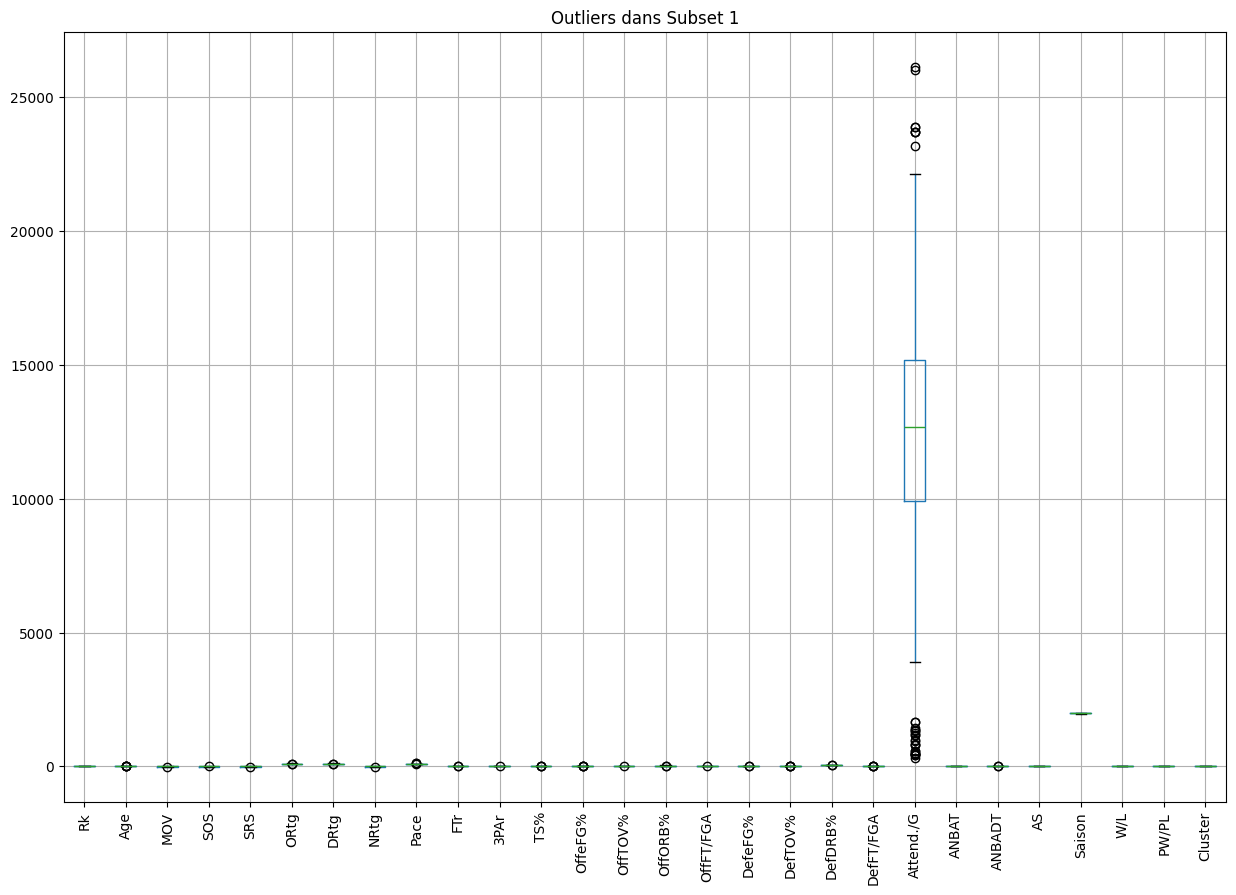

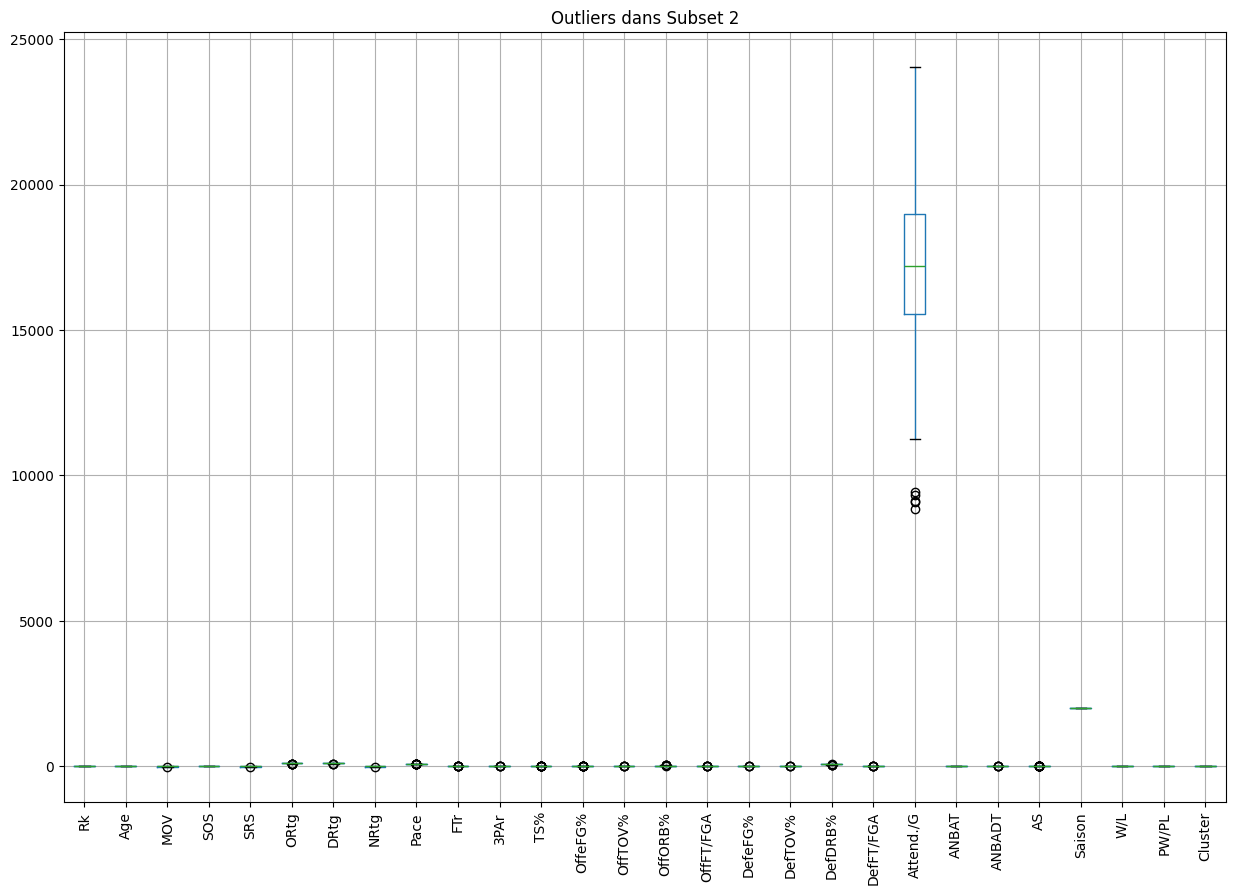

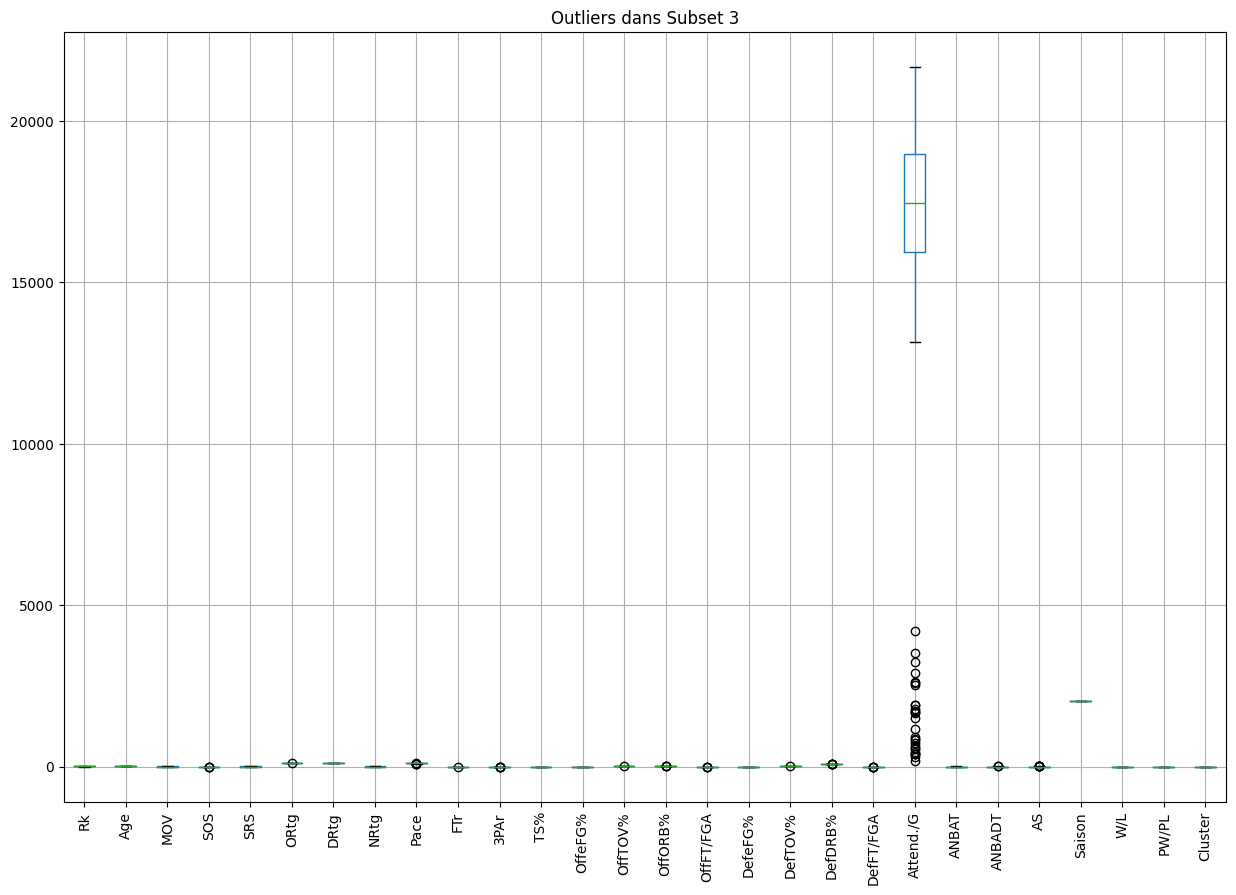

In [14]:
for i, subset in enumerate(sub_sets):
    subset_num = subset.select_dtypes(include=['float64', 'int64'])
    plt.figure(figsize=(15, 10))
    subset_num.boxplot()
    plt.title(f"Outliers dans Subset {i+1}")
    plt.xticks(rotation=90)
    plt.show()